In [3]:
!pip install netcdf4

You should consider upgrading via the 'C:\Users\zlukich\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [1]:
import netCDF4 as nc
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
pd.options.mode.chained_assignment = None  # default='warn'


# Helping functions

In [2]:
def get_neighbours(df,x,y):
    
    result = pd.DataFrame()
    
    df_cell = df.loc[(df["x"] ==x) & (df["y"] ==y)]
    
    
    new_row_right = df.loc[(df["x"] ==x+1) & (df["y"] ==y)]
   #print(new_row_right)
    if(len(new_row_right) == 0):
        new_row_right = pd.DataFrame({"x" : [x+1 for i in range(df_cell.shape[0])],
                                      "y" : [y for i in range(df_cell.shape[0])],
                                      "emission_value" : [0 for i in range(df_cell.shape[0])],
                                      "hour" : df_cell["hour"].values ,
                                      "nb_type" : ["nbr" for i in range(df_cell.shape[0])]})
    else:
        new_row_right["nb_type"] = "nbr"
    
    
    new_row_left = df.loc[(df["x"] ==x-1) & (df["y"] ==y)]
    if(len(new_row_left) == 0):
        new_row_left = pd.DataFrame({"x" : [x-1 for i in range(df_cell.shape[0])],
                                      "y" : [y for i in range(df_cell.shape[0])],
                                      "emission_value" : [0 for i in range(df_cell.shape[0])],
                                      "hour" : df_cell["hour"].values ,
                                      "nb_type" : ["nbl" for i in range(df_cell.shape[0])]})
    else:
        new_row_left["nb_type"] = "nbl"
    
    
    new_row_up = df.loc[(df["x"] ==x) & (df["y"] ==y-1)]
    if(len(new_row_up) == 0):
        new_row_up = pd.DataFrame({"x" : [x for i in range(df_cell.shape[0])],
                                      "y" : [y-1 for i in range(df_cell.shape[0])],
                                      "emission_value" : [0 for i in range(df_cell.shape[0])],
                                      "hour" : df_cell["hour"].values ,
                                      "nb_type" : ["nbu" for i in range(df_cell.shape[0])]})
    else:
        new_row_up["nb_type"] = "nbu"
    
    
    new_row_down = df.loc[(df["x"] ==x) & (df["y"] ==y+1)]
    if(len(new_row_down) == 0):
        new_row_down = pd.DataFrame({"x" : [x for i in range(df_cell.shape[0])],
                                      "y" : [y+1 for i in range(df_cell.shape[0])],
                                      "emission_value" : [0 for i in range(df_cell.shape[0])],
                                      "hour" : df_cell["hour"].values ,
                                      "nb_type" : ["nbd" for i in range(df_cell.shape[0])]})
    else:
        new_row_down["nb_type"] = "nbd"
    result = pd.concat([new_row_right,new_row_left,new_row_up,new_row_down])
    return result



def add_neighbours(df,x,y):
    '''
    
        df_cell: adds neighbours to specific cell
    '''
    df_cell = df.loc[(df["x"] ==x) & (df["y"] ==y)]
    
    #print(df_cell)
    neighbours = get_neighbours(df,x,y)
    
    neighbours_right = neighbours.loc[neighbours["nb_type"] == "nbr"]
    neighbours_left = neighbours.loc[neighbours["nb_type"] == "nbl"]
    neighbours_up = neighbours.loc[neighbours["nb_type"] == "nbu"]
    neighbours_down = neighbours.loc[neighbours["nb_type"] == "nbd"]
    
    #print(neighbours_right)
    try:
        df_to_append = pd.DataFrame({"nbr":neighbours_right["emission_value"].values,
                                    "nbl":neighbours_left["emission_value"].values,
                                    "nbu":neighbours_up["emission_value"].values,
                                    "nbd":neighbours_down["emission_value"].values})
    except:
        df_to_append = pd.DataFrame()
        print("hello")
        #print(neighbours)
        #print(neighbours_right)
        #print(neighbours_left)
        #print(neighbours_up)
        #print(neighbours_down)
    #print(df_to_append)
    df_to_append = df_to_append.reset_index(drop=True)
    df_cell = df_cell.reset_index(drop=True)
    result= pd.concat([df_cell,df_to_append],axis = 1)
    return result

def complete_df_with_neighbours(df):
    '''
        
    '''
    maximal_x = max(df["x"])
    minimal_x = min(df["x"])
    maximal_y = max(df["y"])
    minimal_y = min(df["y"])
    #print(df.shape[0])
    result = pd.DataFrame()
    for i in range(minimal_x,maximal_x+1,1):
        for j in range(minimal_y,maximal_y+1):
            df_cell = add_neighbours(df,i ,j )
            #print(df_cell)
            result = pd.concat([result,df_cell])
    return result
    

# Reading .nc files

## Chemistry

In [3]:
ds = nc.Dataset("../data/photoshade_6km10m_lod2_chemistry.nc")

## Static

In [24]:
ds_static = nc.Dataset("../data/photoshade_6km10m_lod2_static.nc")
buildings = pd.DataFrame(ds_static["buildings_2d"][:,:].data)
buildings = buildings.melt(var_name = "x",value_name = "building_height")
buildings["y"] = [i%672 for i in range(buildings.shape[0])]
new_cols_order = ["x","y","building_height"]
buildings = buildings[new_cols_order]
buildings.replace(-9999,0,inplace=True) # because strange values where there are no pollutants
buildings

,x,y,building_height
0,0,0,0.000000
1,0,1,7.494203
2,0,2,9.762539
3,0,3,7.645858
4,0,4,0.000000
...,...,...,...
451579,671,667,18.275076
451580,671,668,18.620945
451581,671,669,0.000000
451582,671,670,0.000000


In [25]:
ds_static["buildings_2d"][:,:].data

array([[-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [ 7.4942026e+00,  2.5527954e+00,  2.5908296e+00, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [ 9.7625389e+00,  6.5296469e+00,  2.6172369e+00, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       ...,
       [ 4.5468512e+00, -9.9990000e+03,  2.3736382e+00, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [ 2.3219662e+00, -9.9990000e+03,  4.8464036e+00, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [ 2.1752009e+00, -9.9990000e+03,  5.0833402e+00, ...,
        -9.9990000e+03, -9.9990000e+03,  1.6172220e+01]], dtype=float32)

In [6]:
ds["emission_values"][0,0,:,:,0].data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Save information as CSV file

In [7]:
pd_15hour_3species = pd.DataFrame(ds["emission_values"][15,0,:,:,2].data)

In [8]:
pd_15hour_melted = pd.melt(pd_15hour_3species,var_name = "y",value_name = "emission_value")

In [9]:
pd_15hour_melted["x"] = [i%672 for i in range(pd_15hour_melted.shape[0])]

In [10]:
pd_15hour_melted

,y,emission_value,x
0,0,0.0,0
1,0,0.0,1
2,0,0.0,2
3,0,0.0,3
4,0,0.0,4
...,...,...,...
451579,671,0.0,667
451580,671,0.0,668
451581,671,0.0,669
451582,671,0.0,670


In [11]:
new_cols_order = ["x","y","emission_value"]
pd_15hour_melted = pd_15hour_melted[new_cols_order]
pd_15hour_melted

,x,y,emission_value
0,0,0,0.0
1,1,0,0.0
2,2,0,0.0
3,3,0,0.0
4,4,0,0.0
...,...,...,...
451579,667,671,0.0
451580,668,671,0.0
451581,669,671,0.0
451582,670,671,0.0


### DF concatenation

In [12]:
testx = [i for i in range(0,300,1)]
testy = [i for i in range(100,400,1)]
test = pd.DataFrame(ds["emission_values"][0,0,testy,testx,1].data)
test.index = testy
test.columns = testx
test.shape

(300, 300)

In [40]:
result_nspecies = pd.DataFrame()
xrange = [i for i in range(100,250,1)] # Subsetting specific grid part
yrange = [i for i in range(200,350,1)] # Subsetting specific grid part
for i in range(48):
    pd_ihour_nspecies = pd.DataFrame(ds["emission_values"][i,0,yrange,xrange,0].data) #[hour,z,y,x,species]
    pd_ihour_nspecies.index = yrange
    pd_ihour_nspecies.columns = xrange
    pd_ihour_nspecies = pd.melt(pd_ihour_nspecies,var_name = "x",value_name = "emission_value")
    pd_ihour_nspecies["y"] = [i%len(yrange)+yrange[0] for i in range(pd_ihour_nspecies.shape[0])]
    pd_ihour_nspecies["hour"] = i
    #pd_ihour_nspecies = pd_ihour_nspecies.sort_values(["x","y"])
    #buildings = buildings.sort_values(["x","y"])
    #pd_ihour_nspecies["building_height"] = buildings["building_height"]
    pd_ihour_nspecies=pd.merge(pd_ihour_nspecies,buildings, how= "inner",on = ["x","y"])
    result_nspecies= pd.concat([result_nspecies,pd_ihour_nspecies])


In [41]:
#result_nspecies["building_height"] = buildings.loc[(buildings["x"]<50) & (buildings["y"]<50)]["building_height"]
new_cols_order = ["x","y","hour","building_height","emission_value"]
result_nspecies= result_nspecies[new_cols_order]
result_nspecies

,x,y,hour,building_height,emission_value
0,100,200,0,0.0,0.0
1,100,201,0,0.0,0.0
2,100,202,0,0.0,0.0
3,100,203,0,0.0,0.0
4,100,204,0,0.0,0.0
...,...,...,...,...,...
22495,249,345,47,0.0,0.0
22496,249,346,47,0.0,0.0
22497,249,347,47,0.0,0.0
22498,249,348,47,0.0,0.0


In [15]:
result_1species_output.loc[(( result_nspecies["x"] == 145) & (result_nspecies["y"] == 245))]

NameError: name 'result_1species_output' is not defined

# PALM Output files

### Download

In [16]:
output_emissions_no2_0 = nc.Dataset("../data/photoshade_6km10m_lod2_av_masked_M01.000.nc")
output_emissions_no2_1 = nc.Dataset("../data/photoshade_6km10m_lod2_av_masked_M01.001.nc")
output_emissions_no2_2 = nc.Dataset("../data/photoshade_6km10m_lod2_av_masked_M01.002.nc")
output_emissions_no2_3 = nc.Dataset("../data/photoshade_6km10m_lod2_av_masked_M01.003.nc")
output_emissions_no2_4 = nc.Dataset("../data/photoshade_6km10m_lod2_av_masked_M01.004.nc")

output_emissions_no2_list = [output_emissions_no2_0,
                             output_emissions_no2_1,
                             output_emissions_no2_2,
                             output_emissions_no2_3,
                             output_emissions_no2_4,]

In [17]:
output_emissions_no2_0

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: PALM 21.10  run: photoshade_6km10m_lod2.00  host: basit  2022-06-17 16:48:38
    Conventions: CF-1.7
    creation_time: 2022-06-17 16:48:38 +02
    data_content: podsmasked
    version: 1
    origin_time: 2017-07-17 00:00:00 +00
    origin_lat: 52.48975372314453
    origin_lon: 13.273119926452637
    origin_x: 382751.5
    origin_y: 5816914.0
    origin_z: 25.382944107055664
    rotation_angle: 0.0
    dependencies: 
    history: 
    author: Basit Khan, basit.khan@kit.edu
    contact_person: 
    institution: Karlsruher Institute of Technology, IMK-IFU, Alpin Campus, GaPa
    acronym: KIT/IMK-IFU
    campaign: summer iop02
    location: Berlin
    site: Berlin Mitte
    source: PALM 21.10
    references: text
    keywords: text
    licence: 
    comment: created with palm_csd
    time_avg:  3600.0 s avg
    VAR_LIST: ;kc_NO;kc_NO2;kc_O3;kc_PM10;
    dimensions(sizes): time(3), ku_above_sur

### Need to reformat to match input emissions grid dataframe

In [42]:
result_1species_output = pd.DataFrame()
xrange = [i for i in range(100,250,1)] # Subsetting specific grid part
yrange = [i for i in range(200,350,1)] # Subsetting specific grid part
pollutant = "kc_NO2"
for output_table in output_emissions_no2_list:
    timebins = (output_table["time"][:].data/3600).astype(int) # getting hours array (after conversion from seconds to hours)
    for i in range(len(timebins)):
        pd_ihour_1species = pd.DataFrame(output_table[pollutant][i,0,yrange,xrange].data)#(netcdf format [hour,y,x])
        pd_ihour_1species.index = yrange
        pd_ihour_1species.columns = xrange
        pd_ihour_1species = pd.melt(pd_ihour_1species,var_name = "x",value_name = "emission_value")
        pd_ihour_1species["y"] = [i%len(yrange)+yrange[0] for i in range(pd_ihour_nspecies.shape[0])]
        pd_ihour_1species["hour"] = timebins[i]-1
        result_1species_output= pd.concat([result_1species_output,pd_ihour_1species])

In [43]:
result_1species_output.replace(-9999,0,inplace=True) # because strange values where there are no pollutants
result_1species_output = result_1species_output[["x","y","hour","emission_value"]]
result_1species_output

,x,y,hour,emission_value
0,100,200,0,0.010562
1,100,201,0,0.010540
2,100,202,0,0.010534
3,100,203,0,0.010544
4,100,204,0,0.010544
...,...,...,...,...
22495,249,345,47,0.018223
22496,249,346,47,0.018224
22497,249,347,47,0.018220
22498,249,348,47,0.018217


# Plot pollution distribution

In [20]:
def make_heatmap_from_pd(result_dataframe,hour,target_name = "emission_value"):
    result_1specieshour = result_dataframe.loc[result_dataframe["hour"] == hour]
    result_1specieshour = result_1specieshour[["x","y",target_name]]
    x = result_1specieshour["x"].max() - result_1specieshour["x"].min() + 1
    y = result_1specieshour["y"].max() - result_1specieshour["y"].min() + 1
    v = result_1specieshour[target_name].to_numpy().reshape((x, y))
    indices = result_1specieshour[["x", 'y']].to_numpy().T
    indices[0] = indices[0] - indices[0].min()
    indices[1] = indices[1] - indices[1].min()

    v = np.tile(np.nan, indices.max(axis=1)+1)
    v[tuple(indices)] = result_1specieshour[target_name]
    ax = sns.heatmap(v)
    ax.invert_yaxis()
    plt.show()

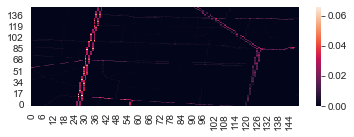

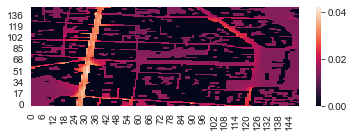

In [44]:
#plotting
hour = 36
plt.subplot(2,1,1)
make_heatmap_from_pd(result_nspecies,hour,target_name="emission_value")
plt.subplot(2,1,2)
make_heatmap_from_pd(result_1species_output,hour,target_name="emission_value")

In [ ]:
result_1species_output.loc[(result_1species_output["emission_value"] > 0) & (result_1species_output["hour"] == 0)].describe()

In [ ]:
result_1species_output.loc[(result_1species_output["emission_value"]!=0) & (result_1species_output["hour"]==24)].describe()

In [ ]:
b_height = ds_static["buildings_2d"][:,:].data
b_height[b_height == -9999] = 0
ax = sns.heatmap(b_height)
plt.show()

In [ ]:
make_heatmap_from_pd(result_nspecies,hour,target_name="building_height")

In [ ]:
#Plot ranges
xrange = [i for i in range(0,670,1)]
yrange = [i for i in range(0,670,1)]
#Data preparing
in_data = ds["emission_values"][0,0,yrange,xrange,1].data          #[hour,z,y,x,nspecies]
out_data = pd.DataFrame(output_emissions_no2_3["kc_NO"][0,0,yrange,xrange].data) #[hour,ku_surf_above,y,x]
out_data[out_data ==-9999] = 0
#plotting
plt.subplot(2,1,1)
ax = sns.heatmap(in_data)
plt.show()
plt.subplot(2,1,2)
ax = sns.heatmap(out_data)
plt.show()

# Outputing relevant information in csvs

In [45]:
completed_1species = complete_df_with_neighbours(result_nspecies)
completed_1species

,x,y,hour,building_height,emission_value,nbr,nbl,nbu,nbd
0,100,200,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100,200,1,0.0,0.0,0.0,0.0,0.0,0.0
2,100,200,2,0.0,0.0,0.0,0.0,0.0,0.0
3,100,200,3,0.0,0.0,0.0,0.0,0.0,0.0
4,100,200,4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
43,249,349,43,0.0,0.0,0.0,0.0,0.0,0.0
44,249,349,44,0.0,0.0,0.0,0.0,0.0,0.0
45,249,349,45,0.0,0.0,0.0,0.0,0.0,0.0
46,249,349,46,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
completed_1species_out = complete_df_with_neighbours(result_1species_output)
completed_1species_out

,x,y,hour,emission_value,nbr,nbl,nbu,nbd
0,100,200,0,0.010562,0.010604,0.000000,0.000000,0.010540
1,100,200,1,0.009452,0.009498,0.000000,0.000000,0.009446
2,100,200,2,0.009615,0.009675,0.000000,0.000000,0.009610
3,100,200,3,0.014870,0.015073,0.000000,0.000000,0.014857
4,100,200,4,0.013692,0.013605,0.000000,0.000000,0.013702
...,...,...,...,...,...,...,...,...
43,249,349,43,0.011732,0.000000,0.011800,0.011717,0.000000
44,249,349,44,0.013980,0.000000,0.014070,0.013944,0.000000
45,249,349,45,0.017794,0.000000,0.017873,0.017751,0.000000
46,249,349,46,0.018918,0.000000,0.018957,0.018886,0.000000


In [47]:
completed_1species.to_csv("../data/result1_species_in.csv",index=False,sep =";",encoding='utf-8', float_format='%.15f')
completed_1species_out.to_csv("../data/result1_species_out.csv",index=False,sep =";",encoding='utf-8', float_format='%.15f')
